# DSO 522: Applied Time Series Analysis for Forecasting

## Week 3: Time Series Features

### Fall 2024

#### Instructor: Ron Li (substitute teaching for Dr. Matteo Sesia)
<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Time Series Features

We can compute many different features on many different time series, and use them to explore the properties of the series. In this chapter we will look at some features that have been found useful in time series exploration, and how they can be used to uncover interesting information about your data.

## 4.1 Simple Statstics Review

We are interested in the following standard statisitcs in general

1. Mean
2. Standard Deviation
3. Variance
4. Median
5. Maximum
6. Minimum
7. Percentange/quantiles

In [9]:
tourism |>
  head()

Quarter,Region,State,Purpose,Trips
<qtr>,<chr>,<chr>,<chr>,<dbl>
1998 Q1,Adelaide,South Australia,Business,135.0777
1998 Q2,Adelaide,South Australia,Business,109.9873
1998 Q3,Adelaide,South Australia,Business,166.0347
1998 Q4,Adelaide,South Australia,Business,127.1605
1999 Q1,Adelaide,South Australia,Business,137.4485
1999 Q2,Adelaide,South Australia,Business,199.9126


Let's calculate the mean, standard deviation, variance and median.

In [14]:
library(fpp3)
tourism |>
  features(Trips, list(mean = mean, sd = sd, var = var, median = median)) |>
  arrange(mean) |>
  head()

Region,State,Purpose,mean,sd,var,median
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Kangaroo Island,South Australia,Other,0.3403467,0.8469782,0.7173721,0
MacDonnell,Northern Territory,Other,0.4490043,1.0040421,1.0081005,0
Wilderness West,Tasmania,Other,0.4782684,1.3478614,1.8167302,0
Barkly,Northern Territory,Other,0.6323856,1.3711961,1.8801788,0
Clare Valley,South Australia,Other,0.8977490,1.5349902,2.3561949,0
Barossa,South Australia,Other,1.0215210,1.7526117,3.0716476,0


> Quiz: How does the `features()` syntax work?

Let's calculate the quantiles.

In [17]:
tourism |> 
    features(Trips, quantile) |>
    head()

Region,State,Purpose,0%,25%,50%,75%,100%
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adelaide,South Australia,Business,68.72539,133.893462,152.576618,176.935536,242.49437
Adelaide,South Australia,Holiday,108.03304,134.626822,153.945007,172.256676,223.55741
Adelaide,South Australia,Other,25.90185,43.865901,53.809463,62.523135,107.49466
Adelaide,South Australia,Visiting,136.61115,178.915998,205.581736,229.299111,269.53562
Adelaide Hills,South Australia,Business,0.00000,0.000000,1.255434,3.920368,28.60152
Adelaide Hills,South Australia,Holiday,0.00000,5.767673,8.515966,14.059997,35.75134


> Quiz: How do I get the 33% and 66% quantile?

<details>
  <summary>Answer</summary>
    
  ### Answer code
  ```r
  tourism %>% 
    features(Trips, list(~ quantile(., probs=c(0.33, 0.66))))
  ```
</details>

## 4.2 Auotocorrelation Function and the Coefficient Features

All the autocorrelations of a series can be considered features of that series. We can also summarise the autocorrelations to produce new features; for example, the sum of the first ten squared autocorrelation coefficients is a useful summary of how much autocorrelation there is in a series, regardless of lag.

The `feat_acf()` function computes a selection of the autocorrelations discussed here. It will return six or seven features

1. The first autocorrelation coefficient from the original data: `acf1`
2. The sum of squares of the first ten autocorrelation coefficients from the original data: `acf10`
3. The first autocorrelation coefficient from the differenced data: `diff1_acf1`
4. The sum of squares of the first ten autocorrelation coefficients from the differenced data `diff1_acf10`
5. The first autocorrelation coefficient from the twice differenced data: `diff2_acf1`
6. The sum of squares of the first ten autocorrelation coefficients from the twice differenced data: `diff2_acf10`
7. For seasonal data, the autocorrelation coefficient at the first seasonal lag is also returned: `season_acf1`.


In [76]:
tourism |> 
    index_by(Quarter) |>
    group_by(State, Purpose) |>
    summarize(Trips = sum(Trips)) |>
    filter(State %in% c("ACT", "Victoria"), Purpose %in% c("Business", "Holiday")) |>
    features(Trips, feat_acf)
    

State,Purpose,acf1,acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,season_acf1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ACT,Business,0.140686820,0.2536752,-0.4374568,0.3352256,-0.6172350,0.5499812,0.3338322
ACT,Holiday,0.087705694,0.3117059,-0.5890306,1.3361565,-0.7699234,2.2997782,0.2996883
Victoria,Business,0.513452701,1.1069280,-0.3136359,0.8416255,-0.4881117,0.7948649,0.5164192
Victoria,Holiday,0.007549892,1.8425769,-0.2390949,2.1963251,-0.3902321,1.9691496,0.8284282


> Quiz: What 

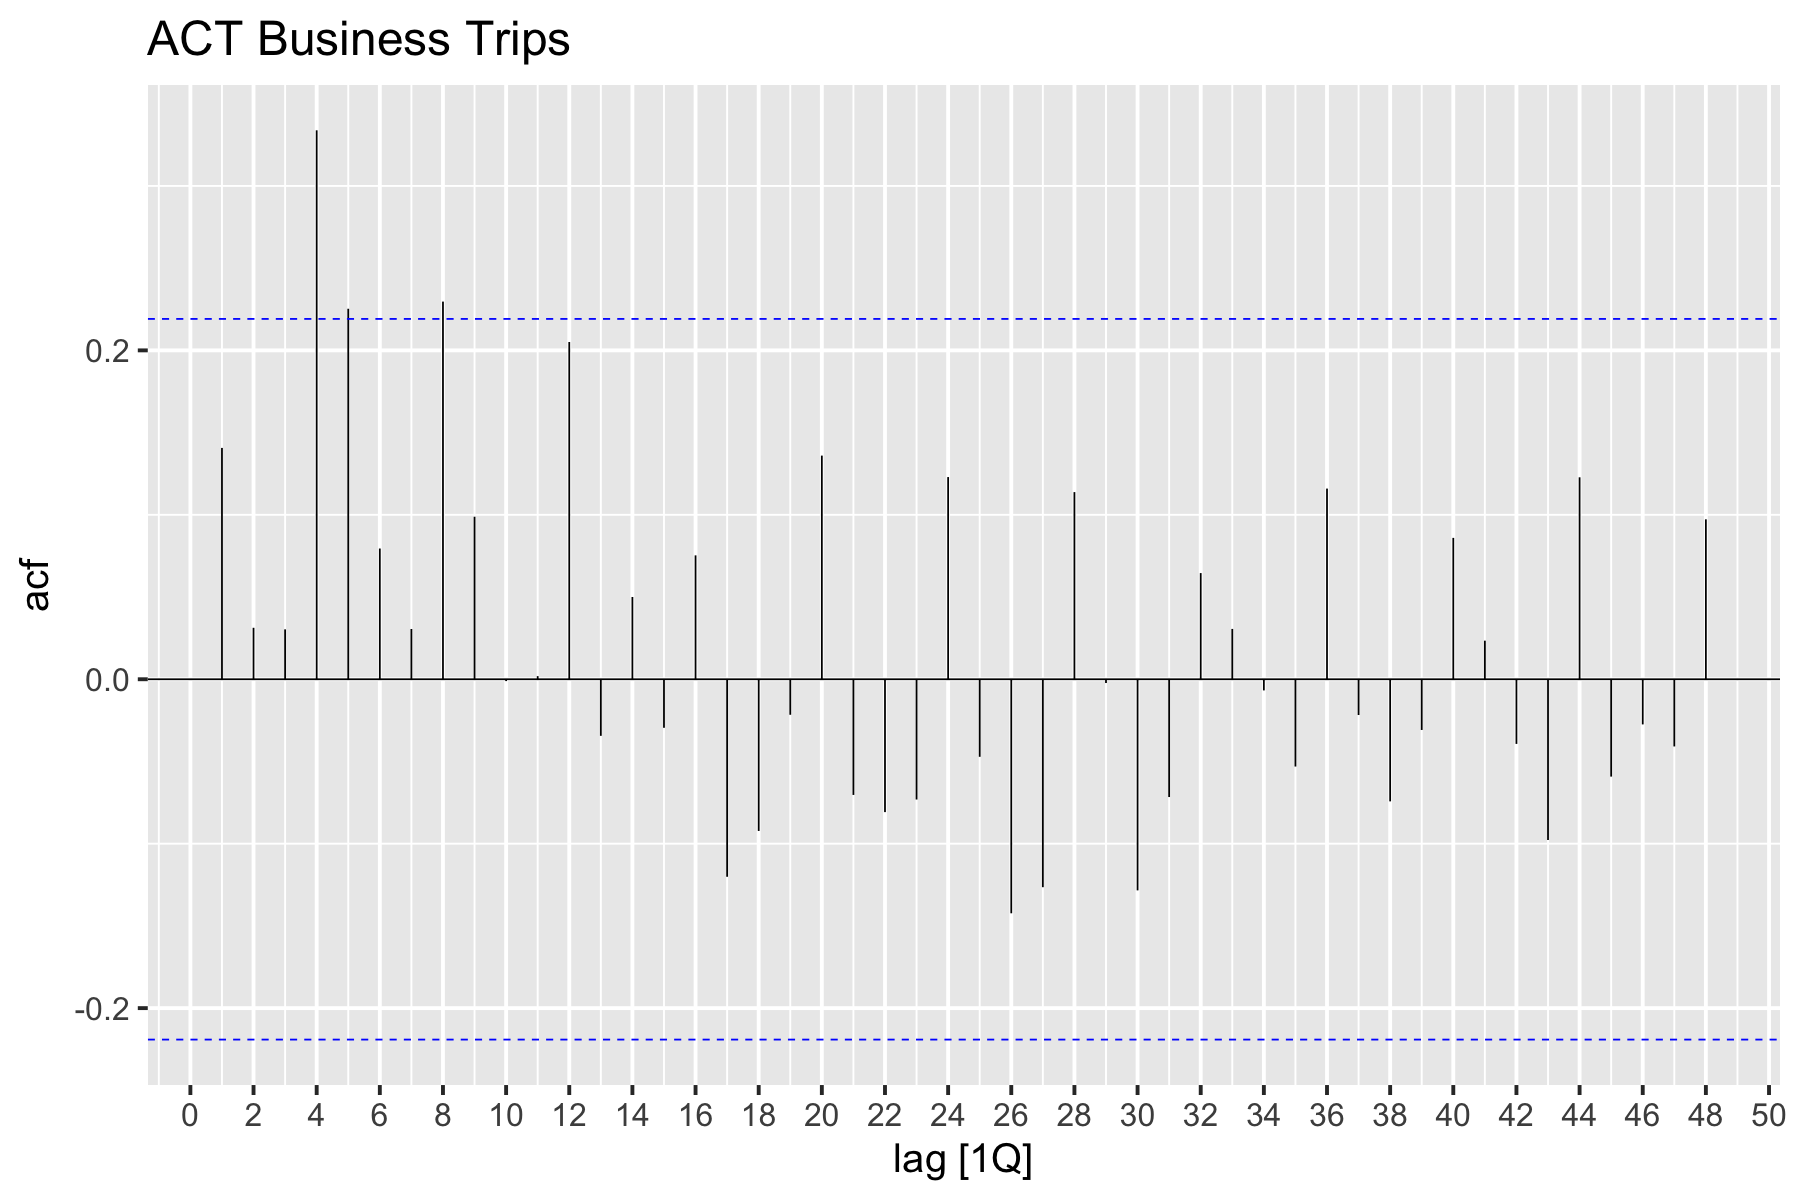

In [65]:
tourism |>
    filter(State == 'ACT', Purpose == 'Business') |>
    index_by(Quarter) |> # Quiz: what's the difference between index_by and group_by?
    summarize(Trips = sum(Trips)) |>
    ACF(Trips, lag_max = 48) |>
    autoplot() +
    labs(title="ACT Business Trips")

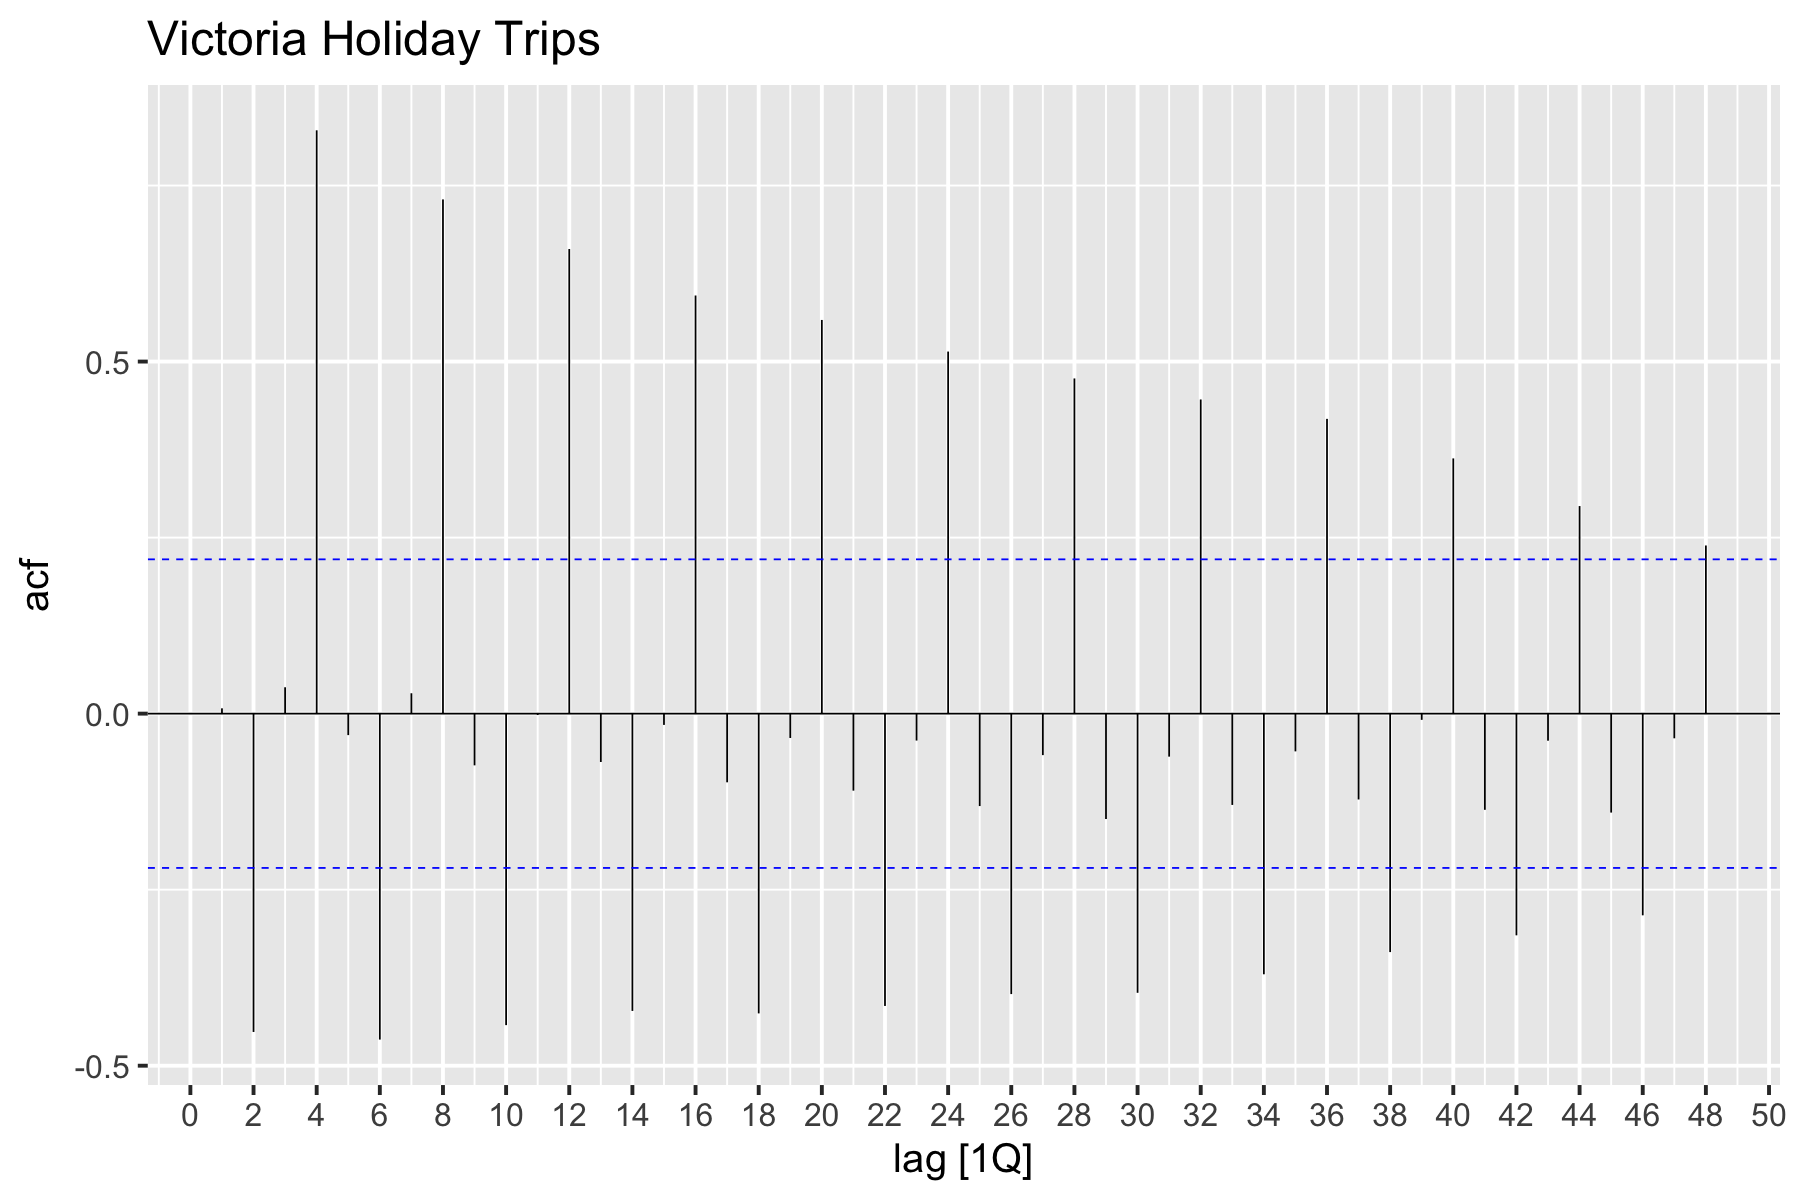

In [63]:
tourism |>
    filter(State == 'Victoria', Purpose == 'Holiday') |>
    index_by(Quarter) |> # Quiz: what's the difference between index_by and group_by?
    summarize(Trips = sum(Trips)) |>
    ACF(Trips, lag_max = 48) |>
    autoplot() +
    labs(title="Victoria Holiday Trips")

> Quiz: What does a large `acf1` but relatively small `acf10` mean?

> Quiz: What does a negative `diff1_acf1` mean?

## 4.3 STL Features

The `STL decomposition` discussed in Chapter 3 is the basis for several more features.

A time series decomposition can be used to measure the strength of trend and seasonality in a time series. Recall that the decomposition is written as


$$ y_t = T_t + S_{t} + R_t$$

#### Measure the strength/contribution of `trend` component and `seasonal` component

For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component. Therefore $\frac{Var(R_t)}{Var(T_t+R_t)}$ should be relatively small.

The strength of trend is defined as:

$$F_T = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t+R_t)}\right)$$

The strength of seasonality is defined similarly, but with respect to the detrended data rather than the seasonally adjusted data:

$$F_S = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_{t}+R_t)}\right)$$

In [29]:
tourism |>
  features(Trips, feat_stl) |>
  head()

Region,State,Purpose,trend_strength,seasonal_strength_year,seasonal_peak_year,seasonal_trough_year,spikiness,linearity,curvature,stl_e_acf1,stl_e_acf10
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adelaide,South Australia,Business,0.4638070,0.4069585,3,1,158.4763481,-5.3126332,71.584178,-0.5323114,0.5939747
Adelaide,South Australia,Holiday,0.5542186,0.6187292,1,2,9.1671559,49.0407477,78.741593,-0.5104023,0.5608486
Adelaide,South Australia,Other,0.7457291,0.2020916,2,1,2.0972085,95.0866802,43.397808,-0.3513377,0.4033702
Adelaide,South Australia,Visiting,0.4354986,0.4518154,1,3,56.1295205,34.5767879,71.375453,-0.5009820,1.0070351
Adelaide Hills,South Australia,Business,0.4641066,0.1793947,3,0,0.1029723,0.9684728,-3.218993,-0.5998442,0.4966204
Adelaide Hills,South Australia,Holiday,0.5275212,0.2958543,2,1,0.1766451,10.4637483,23.997028,-0.4805950,0.3497724


You may find the meaning of extra features like `seasonal_peak_year` in the text book. Now, we focus on the `trend_strength` and `seasonal_strength_year` features.

Intuition tells us that different industries and regions have different behaviors. Let's check it out.

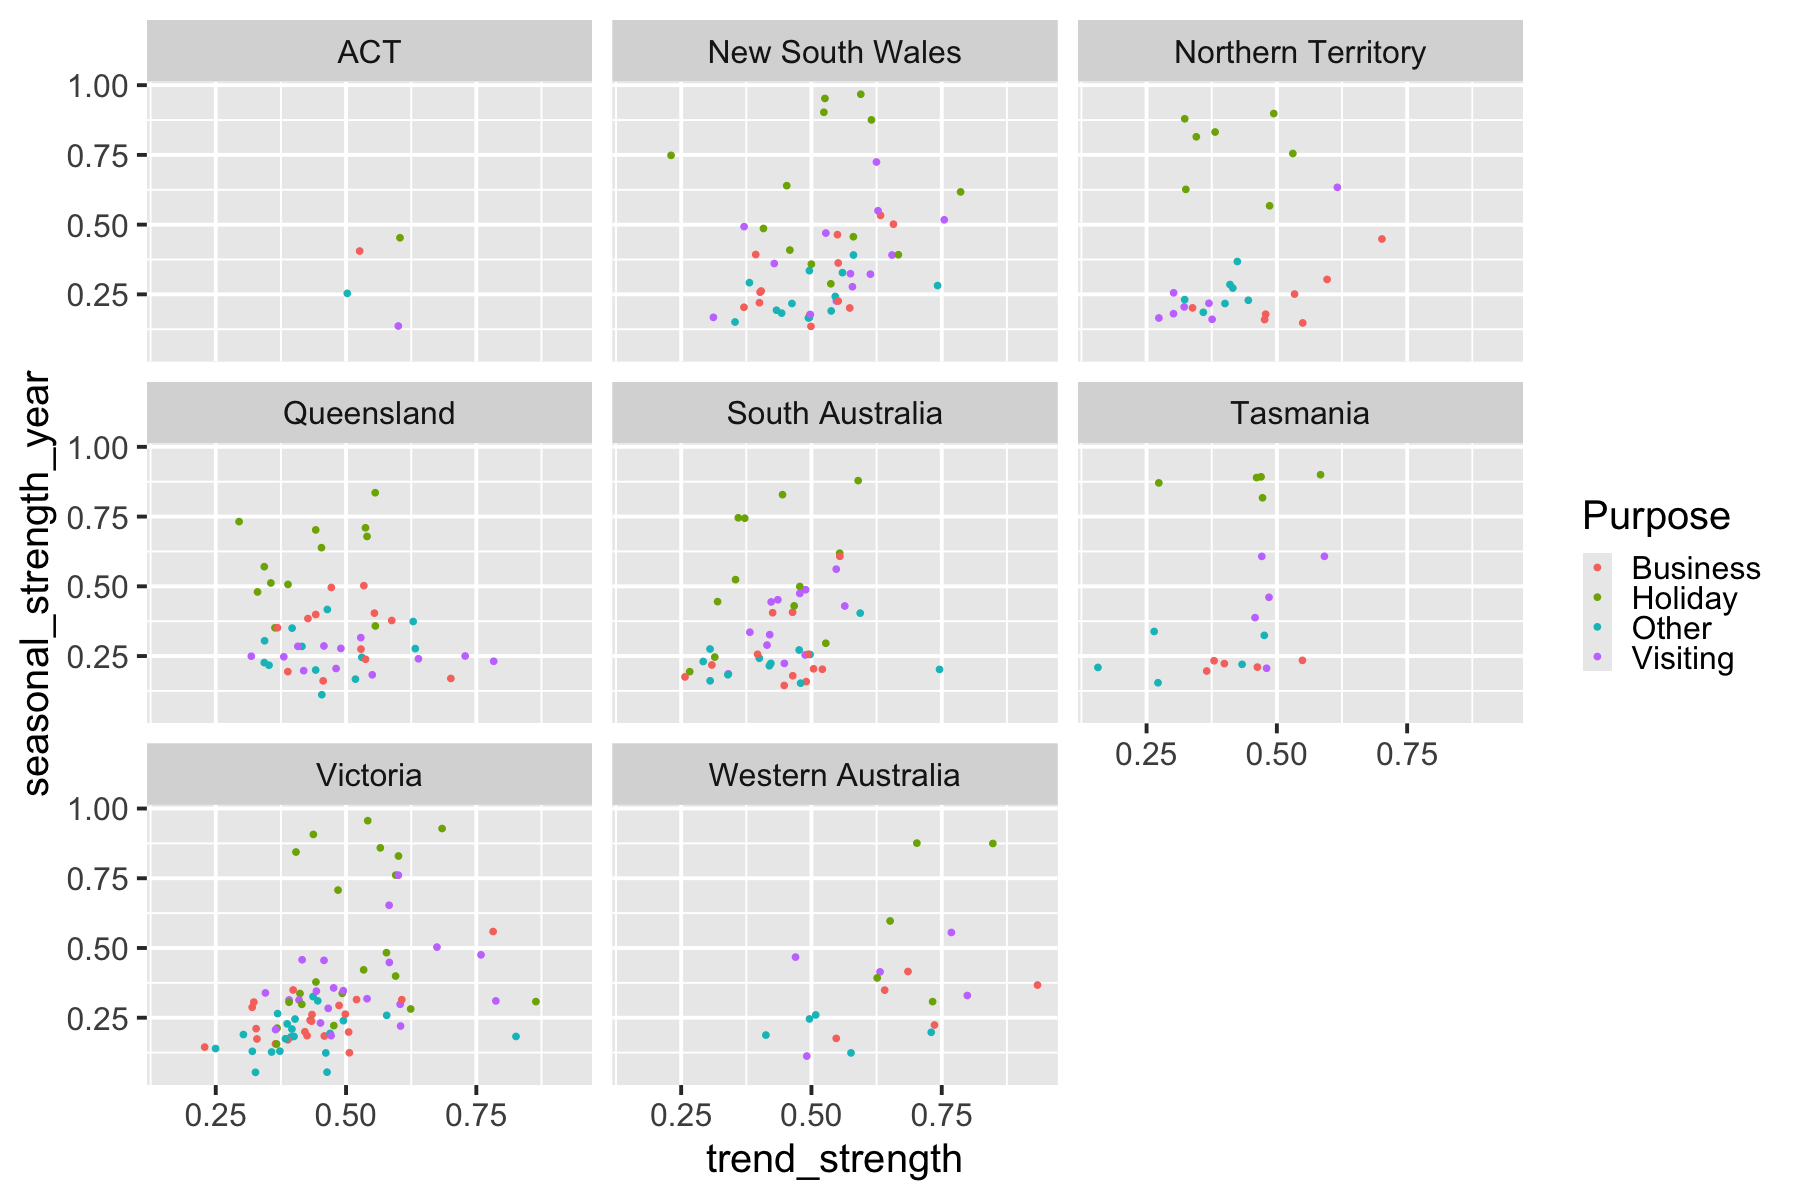

In [35]:
options(repr.plot.width=15, repr.plot.height=10)
theme_set(theme_gray(base_size = 24))
tourism |>
  features(Trips, feat_stl) |>
  ggplot(aes(x = trend_strength, y = seasonal_strength_year,
             col = Purpose)) +
  geom_point() +
  facet_wrap(vars(State))

Clearly, holiday series are most seasonal which is unsurprising. The strongest trends tend to be in Western Australia and Victoria. The most seasonal series can also be easily identified and plotted.

> Quiz: What `question` does the following graph answer exactly compared to the graph above?

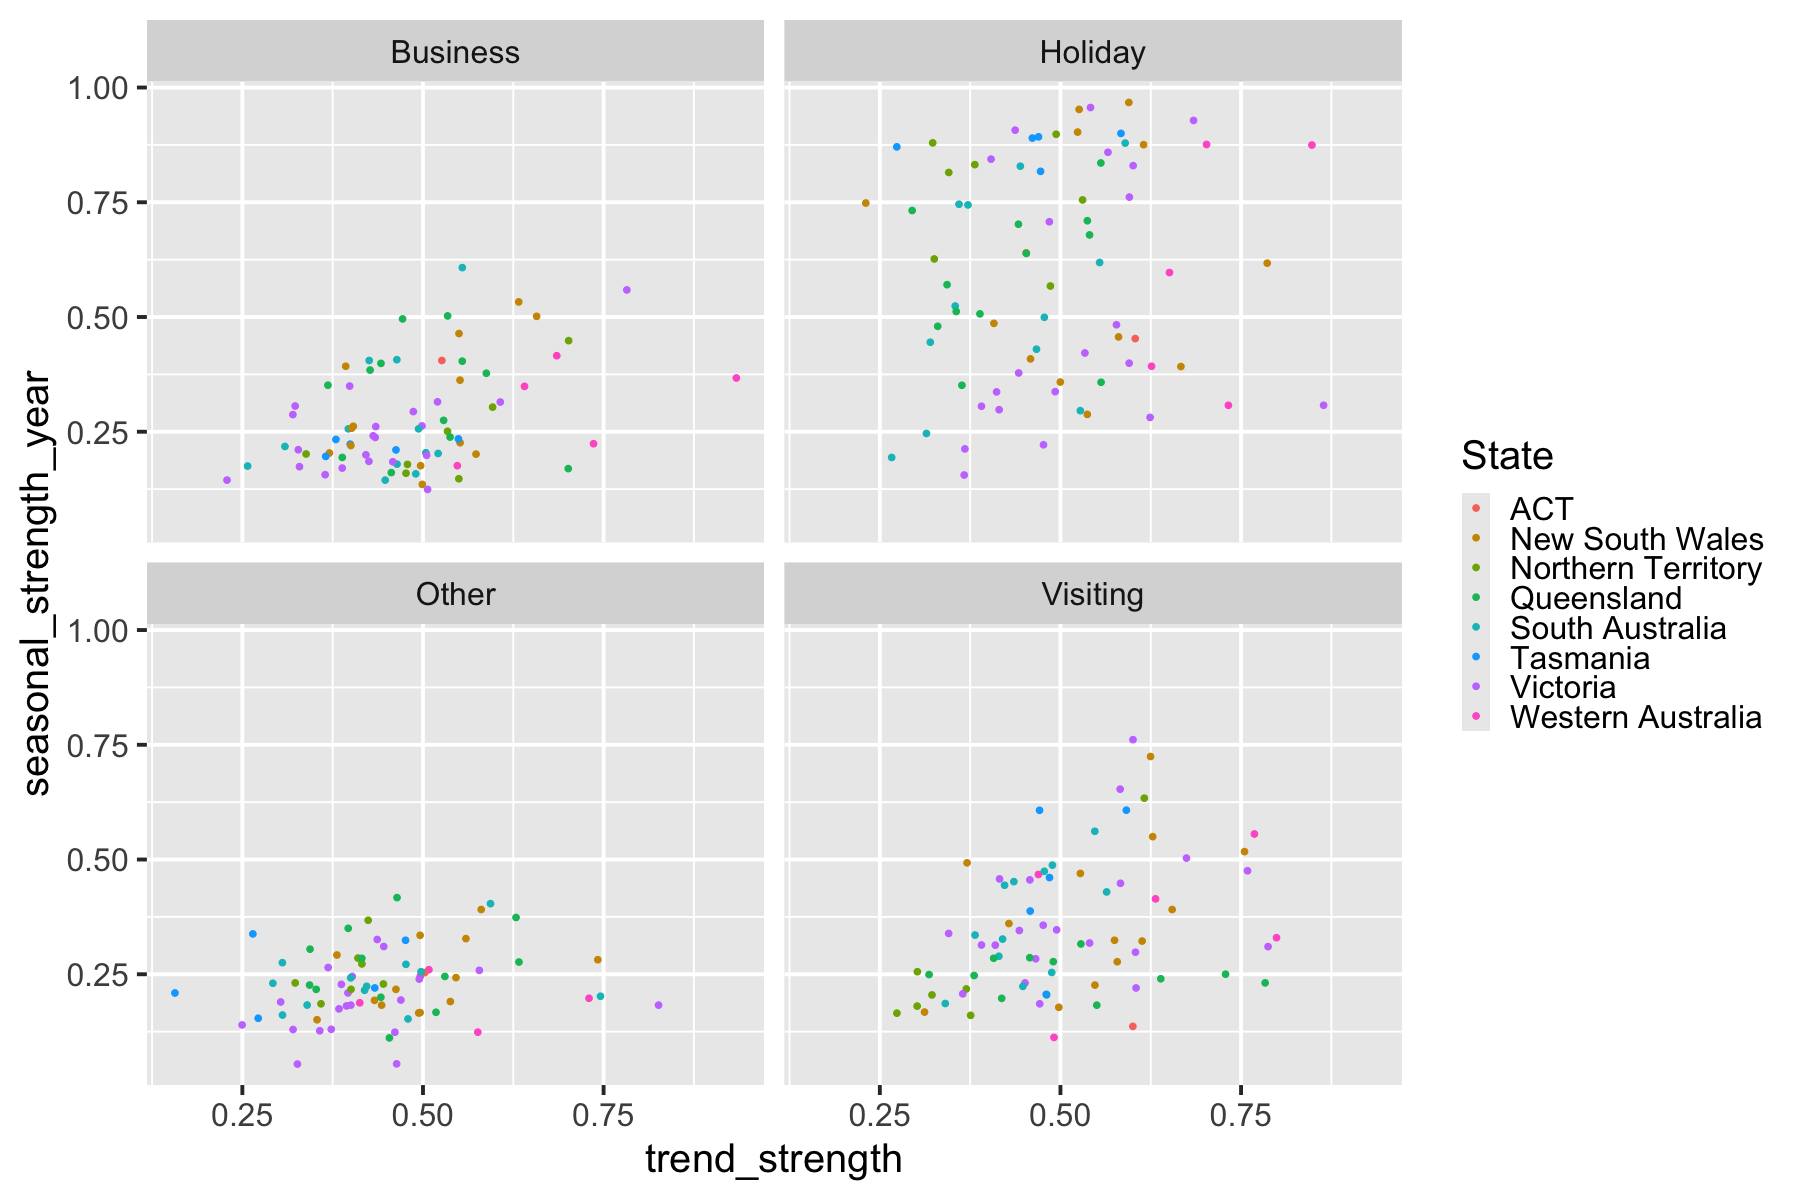

In [37]:
tourism |>
  features(Trips, feat_stl) |>
  ggplot(aes(x = trend_strength, y = seasonal_strength_year,
             col = State)) +
  geom_point() +
  facet_wrap(vars(Purpose))

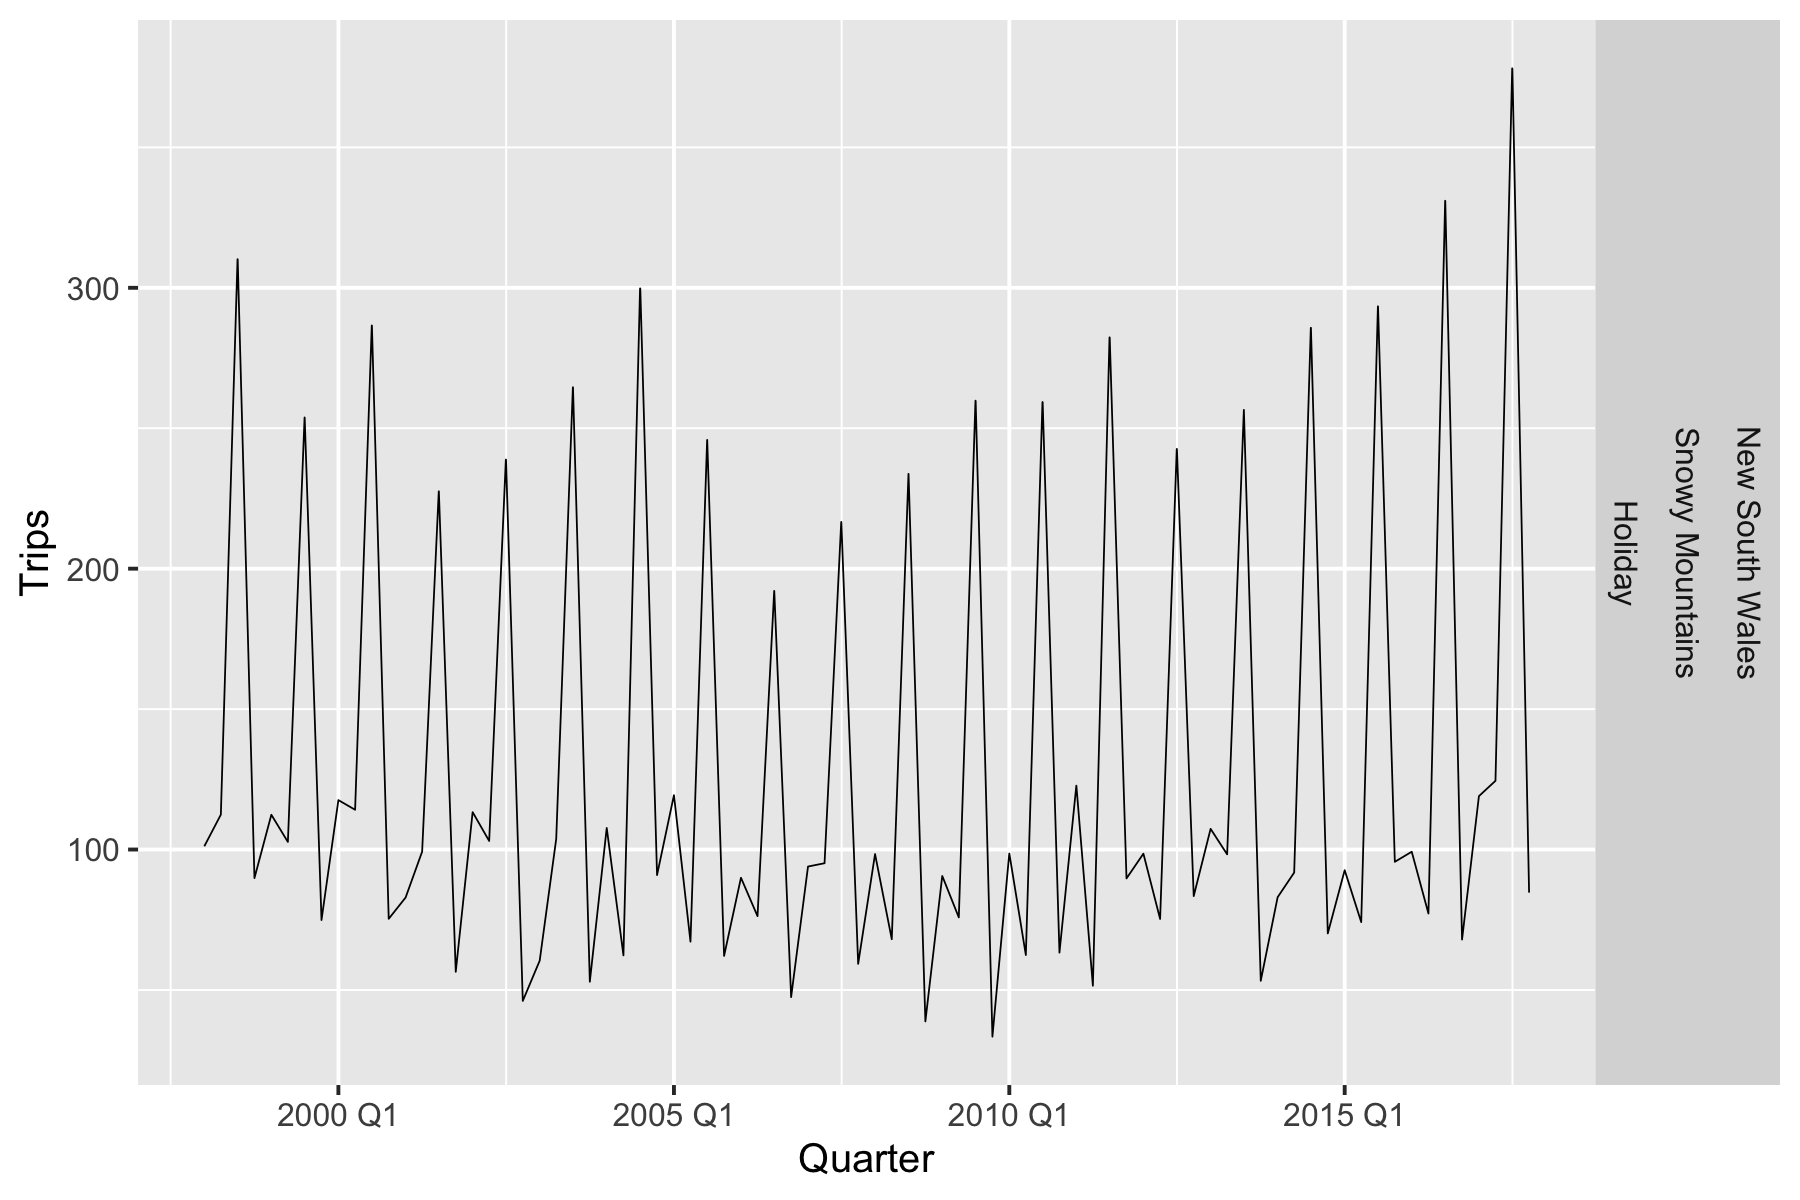

In [44]:
tourism |>
  features(Trips, feat_stl) |>
  filter(
    seasonal_strength_year == max(seasonal_strength_year) 
    # This is a common trick to filter out the maximum
  ) |>
  left_join(tourism, by = c("State", "Region", "Purpose"), multiple = "all") |> 
  # Quiz: what is "multiple" and why it is set to be "all"?
  ggplot(aes(x = Quarter, y = Trips)) +
  geom_line() +
  facet_grid(vars(State, Region, Purpose))

## 4.4 Other Features

There are a few additional features worth mentioning.

1. `coef_hurst` will calculate the Hurst coefficient of a time series which is a measure of “long memory”. A series with long memory will have significant autocorrelations for many lags.
2. `feat_spectral` will compute the (Shannon) spectral entropy of a time series, which is a measure of how easy the series is to forecast. A series which has strong trend and seasonality (and so is easy to forecast) will have entropy close to 0. A series that is very noisy (and so is difficult to forecast) will have entropy close to 1.
3. `box_pierce` gives the Box-Pierce statistic for testing if a time series is white noise, and the corresponding p-value. This test is discussed in Section 5.4.
4. `ljung_box` gives the Ljung-Box statistic for testing if a time series is white noise, and the corresponding p-value. This test is discussed in Section 5.4.
5. `The k-th partial autocorrelation` measures the relationship between observations  
k-periods apart after removing the effects of observations between them. So the first partial autocorrelation is identical to the first autocorrelation, because there is nothing between consecutive observations to remove. Partial autocorrelations are discussed in Section 9.5. The feat_pacf function contains several features involving partial autocorrelations including the sum of squares of the first five partial autocorrelations for the original series, the first-differenced series and the second-differenced series. For seasonal data, it also includes the partial autocorrelation at the first seasonal lag.
6. `unitroot_kpss` gives the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) statistic for testing if a series is stationary, and the corresponding p-value. This test is discussed in Section 9.1.
unitroot_pp gives the Phillips-Perron statistic for testing if a series is non-stationary, and the corresponding p-value.
7. `unitroot_ndiffs` gives the number of differences required to lead to a stationary series based on the KPSS test. This is discussed in Section 9.1
unitroot_nsdiffs gives the number of seasonal differences required to make a series stationary. This is discussed in Section 9.1.
8. `var_tiled_mean` gives the variances of the “tiled means” (i.e., the means of consecutive non-overlapping blocks of observations). The default tile length is either 10 (for non-seasonal data) or the length of the seasonal period. This is sometimes called the “stability” feature.
9. `var_tiled_var` gives the variances of the “tiled variances” (i.e., the variances of consecutive non-overlapping blocks of observations). This is sometimes called the “lumpiness” feature.
shift_level_max finds the largest mean shift between two consecutive sliding windows of the time series. This is useful for finding sudden jumps or drops in a time series.
10. `shift_level_index` gives the index at which the largest mean shift occurs.
shift_var_max finds the largest variance shift between two consecutive sliding windows of the time series. This is useful for finding sudden changes in the volatility of a time series.
11. `shift_var_index` gives the index at which the largest variance shift occurs.
shift_kl_max finds the largest distributional shift (based on the Kulback-Leibler divergence) between two consecutive sliding windows of the time series. This is useful for finding sudden changes in the distribution of a time series.
12. `shift_kl_index` gives the index at which the largest KL shift occurs.
n_crossing_points computes the number of times a time series crosses the median.
longest_flat_spot computes the number of sections of the data where the series is relatively unchanging.
13. `stat_arch_lm` returns the statistic based on the Lagrange Multiplier (LM) test of Engle (1982) for autoregressive conditional heteroscedasticity (ARCH).
14. `guerrero` computes the optimal $\lambda$ value for a Box-Cox transformation using the Guerrero method

## 4.5 Exploring Australian tourism data

One biggest advantage of R is that in a few lines, you can generate some exceptionally informative graphics.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


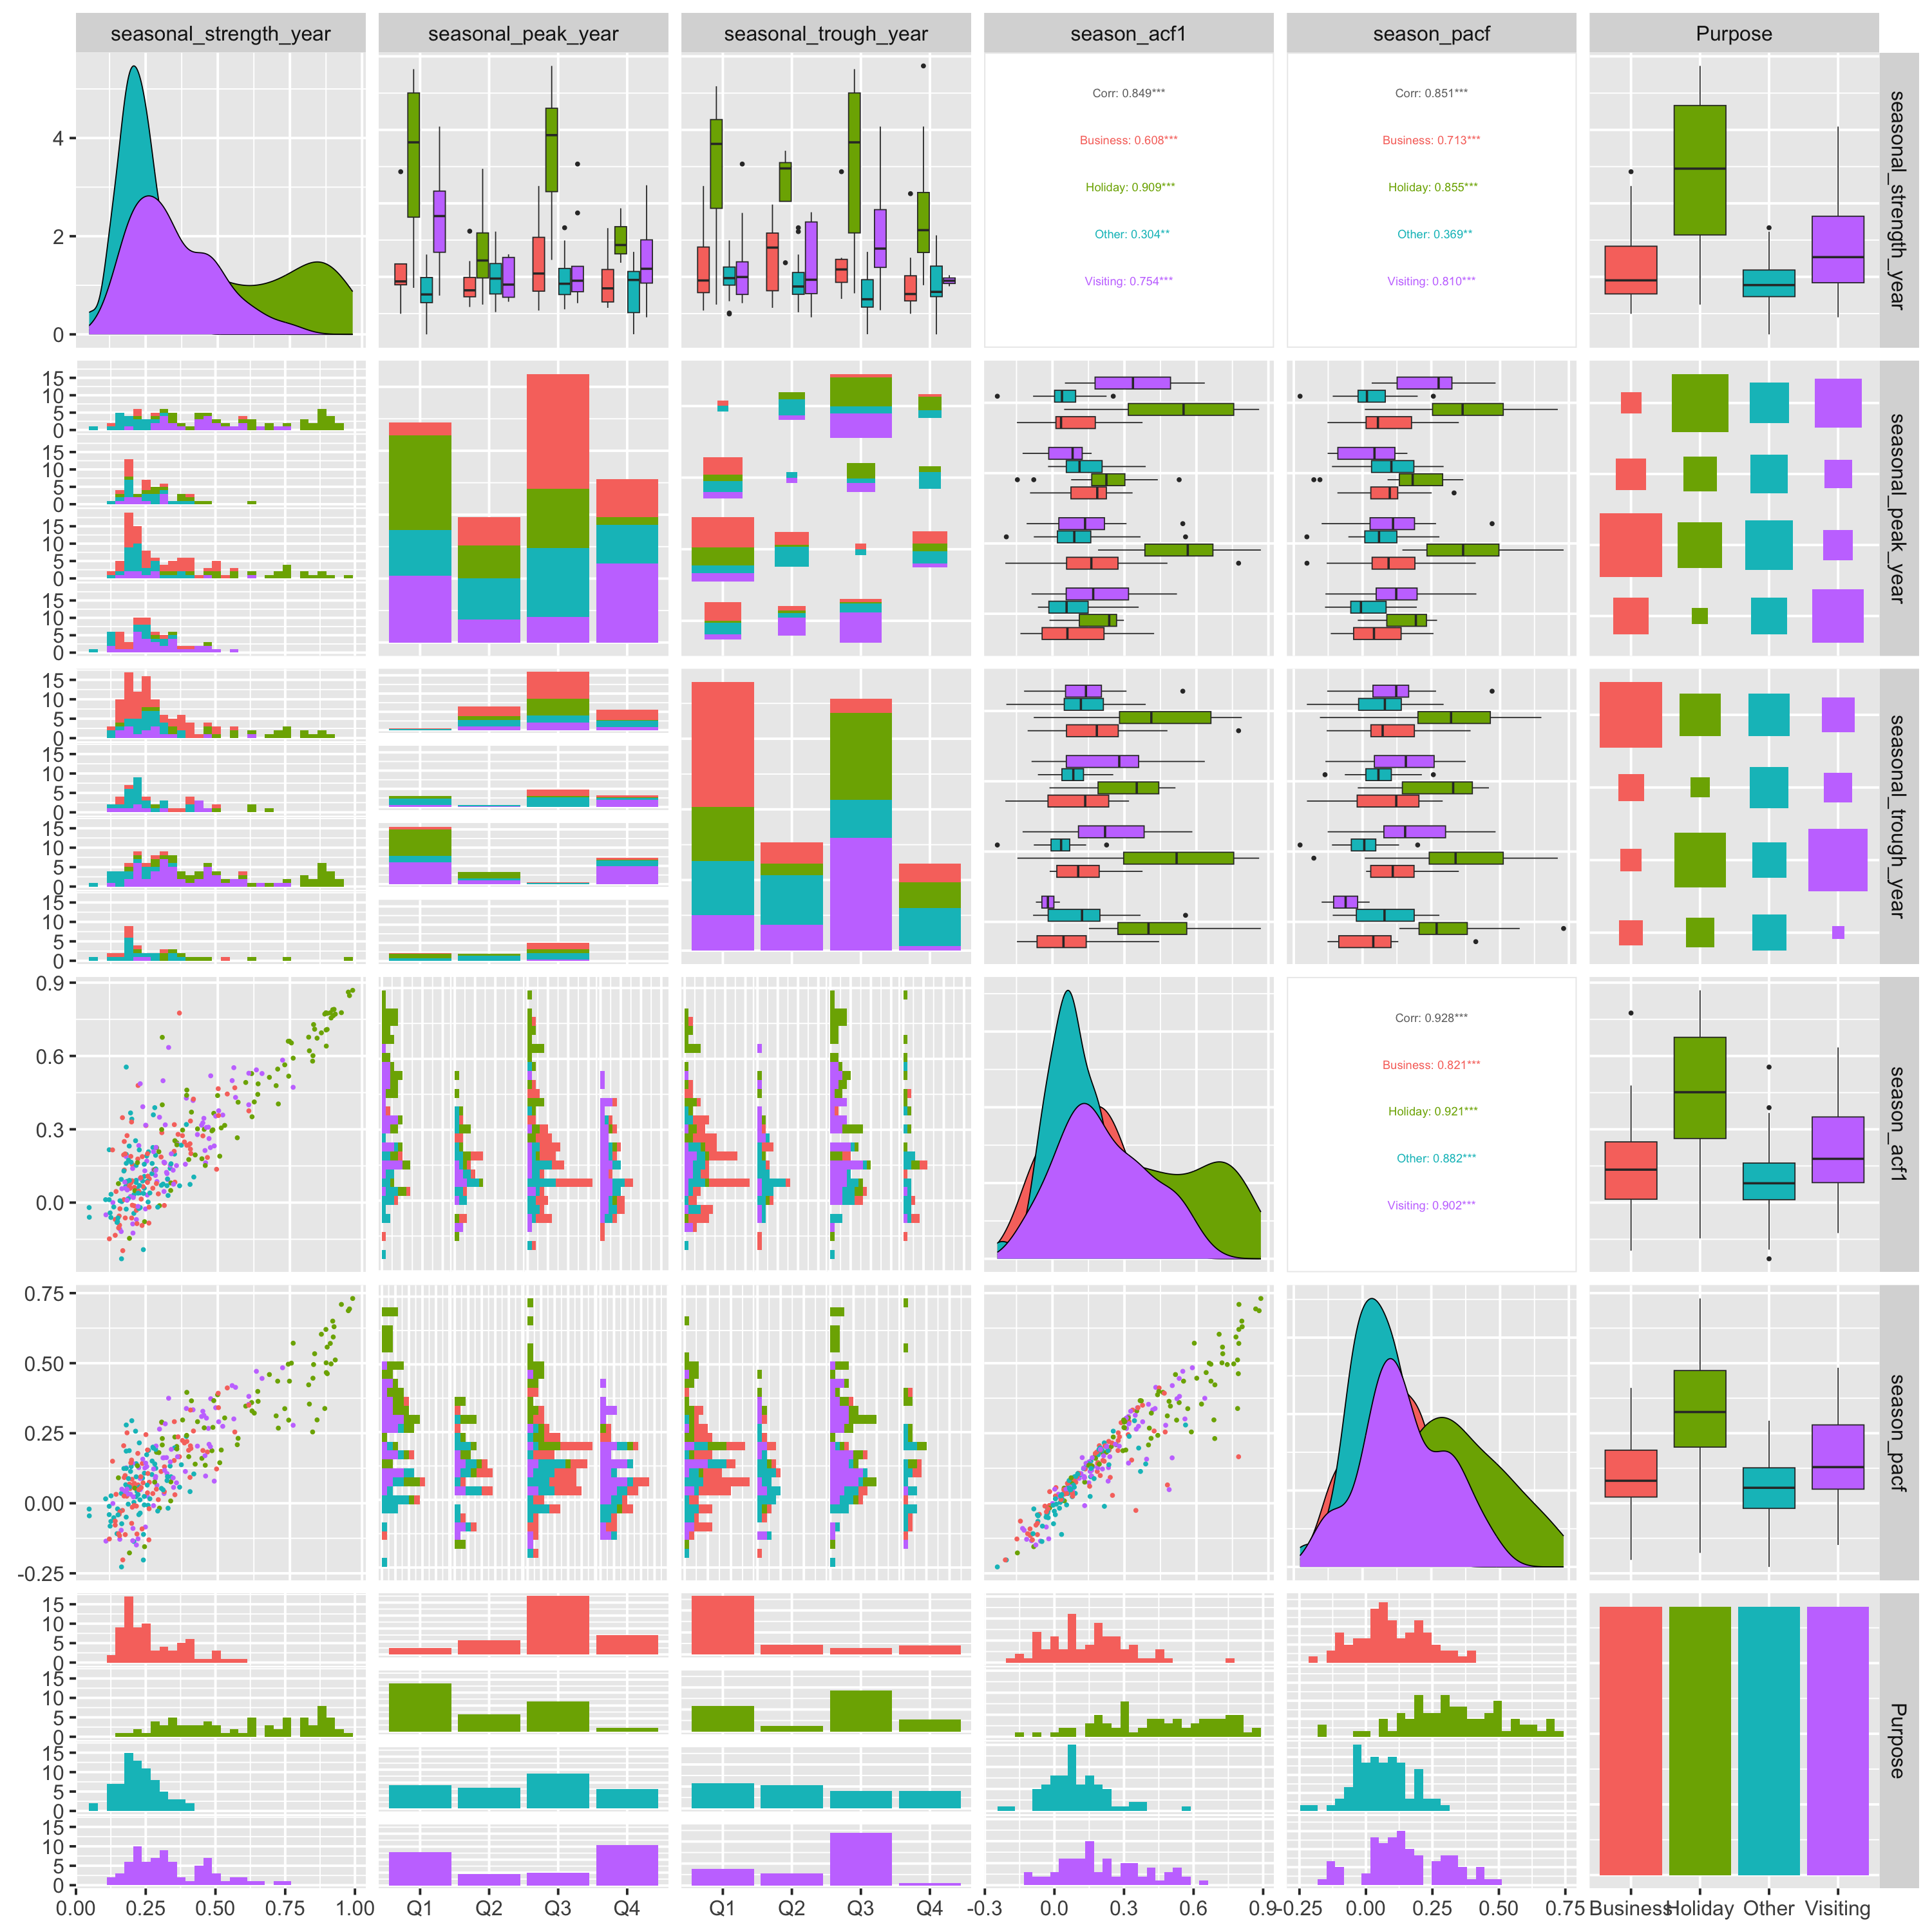

In [80]:
options(repr.plot.width=25, repr.plot.height=25)
library(glue)
tourism_features <- tourism |>
  features(Trips, feature_set(pkgs = "feasts"))

tourism_features |>
  select_at(vars(contains("season"), Purpose)) |>
  mutate(
    seasonal_peak_year = seasonal_peak_year + # Quiz: why 4*(seasonal_peak_year==0)
      4*(seasonal_peak_year==0),
    seasonal_trough_year = seasonal_trough_year +
      4*(seasonal_trough_year==0), 
    seasonal_peak_year = glue("Q{seasonal_peak_year}"), # Task: find out what does `glue` do.
    seasonal_trough_year = glue("Q{seasonal_trough_year}"),
  ) |>
  GGally::ggpairs(mapping = aes(colour = Purpose)) # Task: find out what does `ggpairs` do.

A few discoveries:

1. The three numerical measures related to seasonality (`seasonal_strength_year`, `season_acf1` and `season_pacf`) are all positively correlated.
2. The bottom left panel and the top right panel both show that the most strongly seasonal series are related to holidays (as we saw previously).
3. The bar plots in the bottom row of the `seasonal_peak_year` and `seasonal_trough_year` columns show that seasonal peaks in Business travel occur most often in Quarter 3, and least often in Quarter 1.

### Dimensional Reduction and Principal Component Analysis

It is difficult to explore more than a handful of variables in this way. A useful way to handle many more variables is to use a dimension reduction technique such as principal components. This gives linear combinations of variables that explain the most variation in the original data. We can compute the principal components of the tourism features as follows.


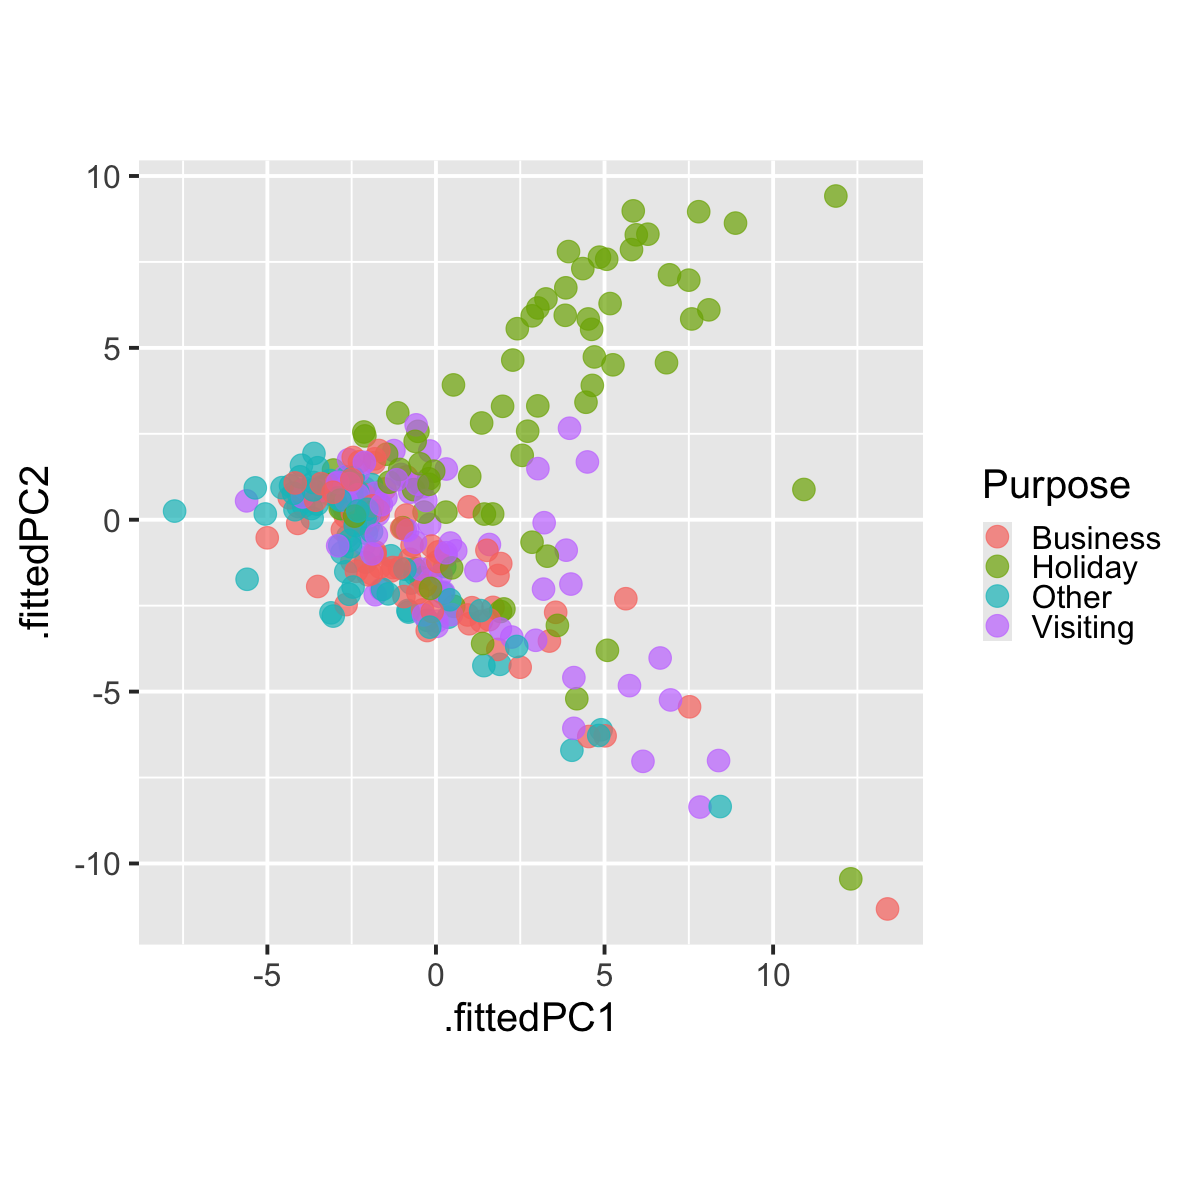

In [85]:
options(repr.plot.width=10, repr.plot.height=10)
library(broom)
pcs <- tourism_features |>
  select(-State, -Region, -Purpose) |>
  prcomp(scale = TRUE) |>
  augment(tourism_features)
pcs |>
  ggplot(aes(x = .fittedPC1, y = .fittedPC2, col = Purpose)) +
  geom_point(size = 6, alpha = 0.7) +
  theme(aspect.ratio = 1)

This figure reveals a few things about the tourism data. First, the holiday series behave quite differently from the rest of the series. Almost all of the holiday series appear in the top half of the plot, while almost all of the remaining series appear in the bottom half of the plot. Clearly, the second principal component is distinguishing between holidays and other types of travel.

The plot also allows us to identify anomalous time series — series which have unusual feature combinations. These appear as points that are separate from the majority of series in this figure. There are four that stand out, and we can identify which series they correspond to as follows.

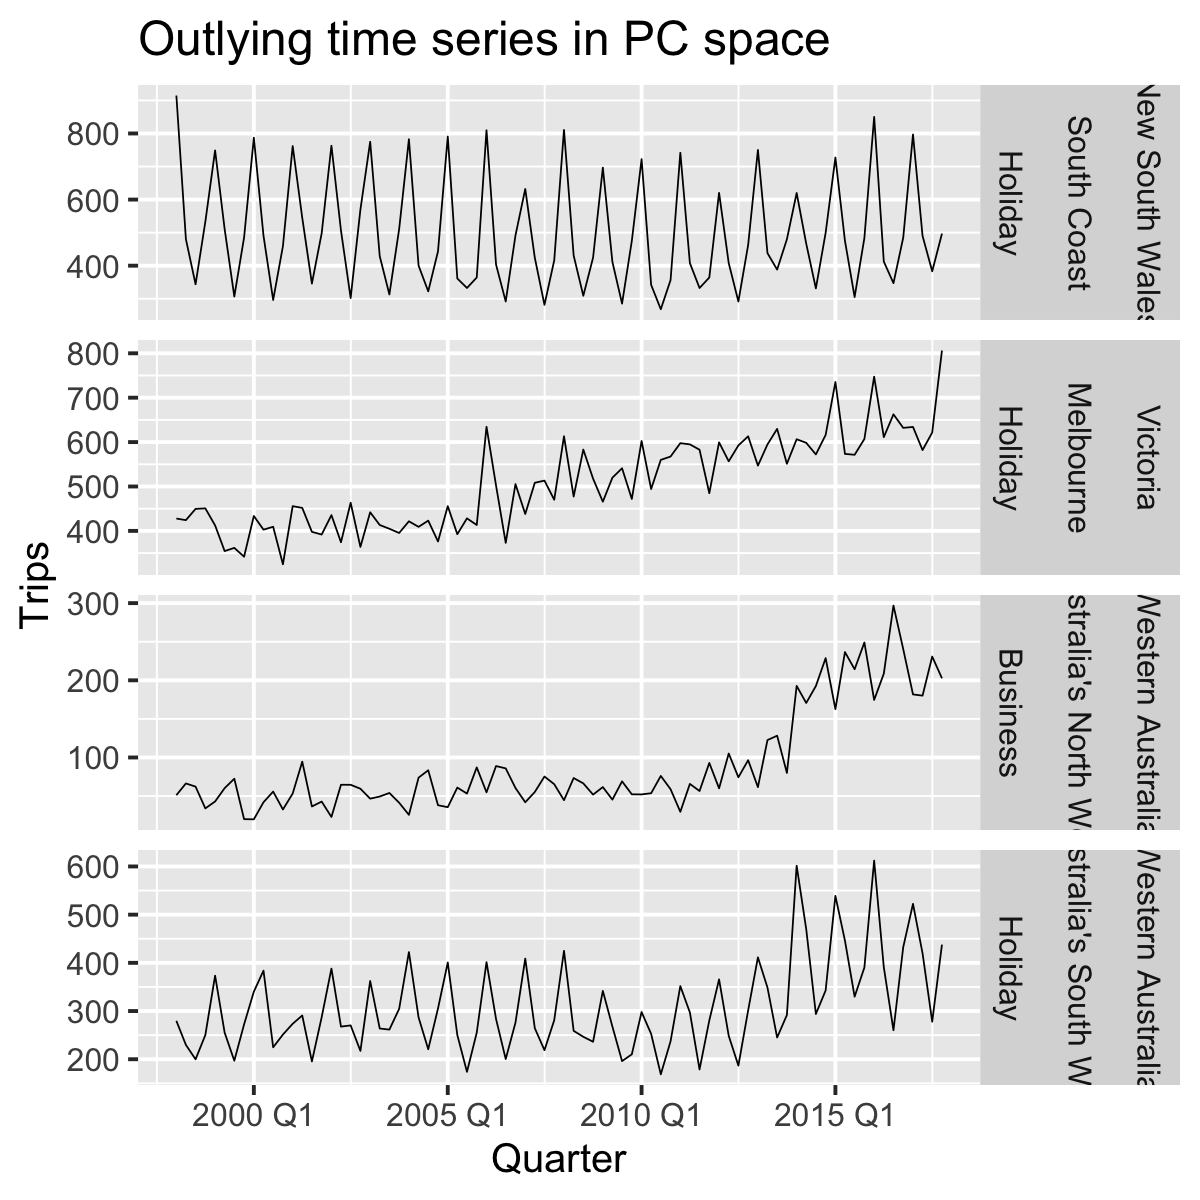

In [87]:
outliers <- pcs |>
  filter(.fittedPC1 > 10) |>
  select(Region, State, Purpose, .fittedPC1, .fittedPC2)

outliers |>
  left_join(tourism, by = c("State", "Region", "Purpose"), multiple = "all") |>
  mutate(Series = glue("{State}", "{Region}", "{Purpose}", .sep = "\n\n")) |>
  ggplot(aes(x = Quarter, y = Trips)) +
  geom_line() +
  facet_grid(Series ~ ., scales = "free") +
  labs(title = "Outlying time series in PC space")

A few discoveries:

1. Holiday visits to the south coast of NSW is highly seasonal but has almost no trend, whereas most holiday destinations in Australia show some trend over time.
2. Melbourne is an unusual holiday destination because it has almost no seasonality, whereas most holiday destinations in Australia have highly seasonal tourism.
3. The north western corner of Western Australia is unusual because it shows an increase in business tourism in the last few years of data, but little or no seasonality.
4. The south western corner of Western Australia is unusual because it shows both an increase in holiday tourism in the last few years of data and a high level of seasonality.